In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

# SLAM Part 1 : Occupancy maps and sensor model
**Overview**

In the present notebook we model the sensor part of the SLAM model: a prior over occupancy maps and poses, and a simulated depth sensor as well as an inverse sensor model:

- $p(m)$ &mdash; Prior over cccupancy map
- $p(x \mid m)$ &mdash; Pose prior (on a given a map)
- $p(z \mid x, m)$ &mdash; Sensor model
- $f(m ; x, z)$ &mdash; Inverse sensor model (deterministic)

**Visual summary**
![sensor_part](png/slam_sensor_part.png)

**Fig: Graphical model.** Graphical representation of the parts that we are modeling here.

![sensor_part](png/sensor_and_occ.png)
![occupancy map](png/inverse_sensor.png)

**Fig: Sensor model.** We implement a simple simulated Lidar sensor on occupancy maps and its inverse model.

In [2]:
using Gen
using Random
using Distributions
using StatsBase: mean, std, quantile
using BenchmarkTools
using FilePathsBase;
using LinearAlgebra: dot, Diagonal, norm
using JSON
import PyPlot
plt = PyPlot.plt
using JLD

include("src/utils.jl");

# Occupancy Map & Pose

In [3]:
abstract type Cell end;

"""
    MapCell(x,v,i)

A single grid cell in an occupancy map.
"""
mutable struct MapCell <: Cell
    x::Vector{Float64}
    v::Float64
    i::CartesianIndex
    # Rem: Could add resolution to each cell...
    # ---
end;


"""
    Map(cells, res)

An occupancy map containing cells of a fixed resolution.
(This could be made variable, and put on the individual cells.)
"""
mutable struct Map
    cells::Array{MapCell}
    res::Float64
end;


Base.size(M::Map) = size(M.cells)
Base.size(M::Map, d::Int) = size(M.cells, d)
Base.iterate(M::Map) = iterate(M.cells)
Base.iterate(M::Map, state) = iterate(M.cells, state)
Base.getindex(M::Map, i) = M.cells[i]
Base.length(M::Map) = length(M.cells)
occupied(M::Map) = filter(c -> c.v > 0.5, M.cells)
walkable(M::Map) = filter(c -> c.v < 0.5, M.cells)
pos(c::MapCell) = c.x
val(c::MapCell) = c.v
pos(M::Map) = hcat(pos.(M.cells)...)
center(M::Map) = mean(pos.(M.cells))
CartesianIndex(t::Int, M::Map, order=:col) = CartesianIndex(t, size(M), order);
expit(M::Map) = expit.(val.(M.cells))
function bounds(M::Map, ϵ=0)
    x = pos(M)
    return [[min(x[1,:]...)-ϵ max(x[1,:]...)+ϵ] 
            [min(x[2,:]...)-ϵ max(x[2,:]...)+ϵ]]
end

function Map(map_size::Tuple{Int,Int}, res::Float64, v0::Array{Float64,2}) 
    i0 = center(map_size)
    cs = Array{MapCell,2}(undef, map_size...)
    for i in CartesianIndices(map_size)    
        cs[i] = MapCell(res.*Vec(i - i0), v0[i], i)
    end
    return Map(cs, res)
end;


Map(map_size::Tuple{Int,Int}, res::Float64, v0::Float64) = Map(map_size, res, v0*ones(map_size...));

In [4]:
function draw_map!(M::Map; ax=plt.gca(),m="o", s=nothing, alpha=.3, c="black", zorder=0)    
    ax.set_aspect(1)    
    occ = occupied(M)
    if length(occ) > 0
        x = hcat(pos.(occ)...)
        ax.scatter(x[1,:],x[2,:], s=s, c=c,marker=m, alpha=alpha, zorder=zorder)
    end
end;

function draw_ell_map!(M::Map; ax=plt.gca(), m="o", s=nothing, alpha=1., cmap="binary", zorder=0)    
    ax.set_aspect(1)    
    x = hcat(pos.(M.cells)...)
    v = expit.(val.(M))
    ax.scatter(x[1,:],x[2,:], s=s, c=v, marker=m, alpha=alpha, cmap=cmap, vmin=0, vmax=1, zorder=zorder)
end;


function draw_map_im!(im::Array{T,2}; ax=plt.gca(), cmap="binary", vmin=-1, vmax=1) where T<: Real
    im = transpose(im)
    im = im[end:-1:1,:]
    ax.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)
end;


function draw_map_circles!(M::Map; ax=plt.gca(), alpha=.2, cmap="binary", zorder=0)     
    cm = plt.cm.get_cmap(cmap)
    ax.set_aspect(1);
    for c in occupied(M)
        circle1 = plt.Circle(c.x, M.res/2, color=cm(c.v), alpha=alpha, zorder=zorder)
        ax.add_patch(circle1)
    end
end;

In [5]:
"""
    map_prior(map_size::Tuple{Int,Int}, 
              res::Float64, 
              pr::Float64) -> M::Map

Returns map of occupancy grid cells with the center 
of the map at the origin.

Choices:
```
    | 
    +-- (:m, CartesianIndex): Bool
```
"""
@gen function map_prior(map_size::Tuple{Int,Int}, 
                        res::Float64, 
                        pr::Float64)
    
    i0    = center(map_size)
    cells = Array{MapCell,2}(undef, map_size...)
    for i in CartesianIndices(map_size)    
        v = @trace(bernoulli(pr), (:m, i))
        cells[i] = MapCell(res.*Vec(i - i0), v, i)
    end

    return Map(cells, res)
end;

# Rem: There should be a quick way to look up the structure of a trace.
# ---  (Maybe providing default arguments as best practice or so??)

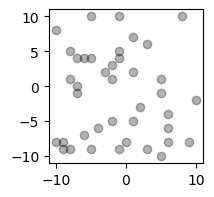

In [6]:
map_args = (map_size=(21,21), res=1., pr=0.1)
M = map_prior(map_args...)

#-----------------------
fig, ax = plt.subplots(1,1, figsize=(4,2));
draw_map!(M, ax=ax);

In [7]:
"""
    Pose

Encoding the pose of a 2d agent as 
a 2d-position `x` and its head direction `hd`.
"""
struct Pose <: StructIterator
    x::Array{Float64}
    hd::Float64
end;


"""
    pose_prior(M::Map)

Samples a pose where the position is uniformly
chosen from the un-occupied cell-centers.

Choices:
```
    | 
    +-- (:hd, Float64)
    |
    +-- (:x,  Array{Float64})
```
"""
@gen function pose_prior(M::Map)
    free = walkable(M)
    len = length(free)
    
    hd ~ uniform(0,2π)
    x  ~ labeled_cat([pos.(free)...], ones(len)/len)
    return Pose(x,hd)
end;

# Rem: Note that pr(hd = -pi) = 0. We need to define a better distr over the unitcircle!
# ---  This was the source of a bug which took quite a bit to unravel...

In [8]:
function draw_pose!(pose; ax=plt.gca(), c="black", m="o", l=1., zorder=1)
    x, hd = pose
    nose = l.*[cos(hd) sin(hd)]
    ax.scatter(x..., c="w", marker="o", edgecolor=c, zorder=zorder+1)
    ax.plot([x[1];x[1]+nose[1]], [x[2];x[2]+nose[2]], c=c, zorder=zorder)
end;

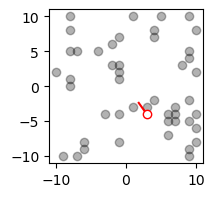

In [9]:
map_args = (map_size=(21,21), res=1., pr=0.1)

M    = map_prior(map_args...)
pose = pose_prior(M)

#-----------------------
fig, ax = plt.subplots(1,1, figsize=(4,2));
draw_map!(M, ax=ax);
draw_pose!(pose, ax=ax, c="r", l=2.);

# Range sensor for grid maps

- see other notebook for different sensor models.

In [10]:
"""
    Measurement(z,a)

Sensor measurement containing depth values `z` and
the angles `a` of the simulated laser beams.
"""
struct Measurement <: StructIterator
    z::Vector{Float64} # range measurements
    a::Vector{Float64} # angles (pre-noise)
end;

In [11]:
function draw_sense!(sense::Measurement, pose::Pose; 
                     ax=plt.gca(), c="C1", alpha=.5, zorder=1, rays=true)

    z, a  = sense
    x, hd = pose

    y = euclidean(z, a .+ hd) .+ x'

    if rays
        for i=1:length(a)
            ax.plot([x[1], y[i,1]],[x[2], y[i,2]], c=c, alpha=0.2, zorder=zorder);
        end
    end
    
    ax.scatter(y[:,1], y[:,2], c=c, alpha=alpha, s=1, zorder=zorder);
    
end;

In [12]:
"""
    angles(fov::Int64=180, n=100)

Range of angles from `-fov` degrees to `+fov` degrees,
however the entries are in radians not degrees.
"""
function angles(fov::Int64, n::Int)
    if fov > 180 || fov <= 0
       throw(DomainError(fov, "fov must satisfy `0 < fov <= 180`")) 
    end
    
    θ  = fov/180*π
    θs = collect(range(-θ, θ, length=n))
    return θs
end;


function angles_and_bins(fov, n)
    if fov > 180 || fov <= 0
       throw(DomainError(fov, "fov must satisfy `0 < fov <= 180`")) 
    end
    
    a = angles(fov, n+1)[1:end-1]
    b = angles(fov, n+1)
    da = a[2] - a[1]
    a .+= da/2
    return a,b
end   


"""
    bin_angles(b, a)

Angles and binedges have to be in [-π, π] (if you're not sure
adjust using the `adjust_angles` function below).
"""
function bin_angles(b, a)
    x  = a .- b[1]
    db = b[2] - b[1]
    return Int.(ceil.(x./db))
end;


adjust_angles(a) = mod.(a .+ π, 2π) .- π;

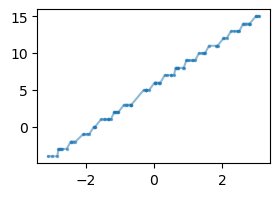

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdd9107ddd0>

In [13]:
a = rand(100)*2π
a = adjust_angles(a)
_,b = angles_and_bins(90, 10)
sort!(a)
# ---------
plt.figure(figsize=(3,2))
plt.plot(a, bin_angles(b, a), marker=".", markersize=3, alpha=0.5)

In [14]:
function polar_lidar(occ, pose, fov, n, max_val)
    
    z = max_val*ones(n)
    a, b = angles_and_bins(fov, n)  
    
    if length(occ) == 0
        return Measurement(z, a), nothing
    end
    
    x, hd = pose
    cx = hcat(pos.(occ)...) .- x       # centered cell positions
    ca = atan.(cx[2,:], cx[1,:]) .- hd # angles of cells
    ca = adjust_angles(ca) 
    
    I  = bin_angles(b, ca)             # index of cell angle wrt bins
    Z = sqrt.(sum(cx.^2, dims=1)[1,:]) # Depth of each cell

    for i=1:n
        z[i] = min(Inf, Z[I .== i]...)
    end
    
    clamp!(z, 0.0, max_val)
    
    return Measurement(z, a), I
end

polar_lidar (generic function with 1 method)

**Remark.** Change the number of laser beams `n` to see the difference in measurements from the two lidar functions, e.g. try `n=10,100`.

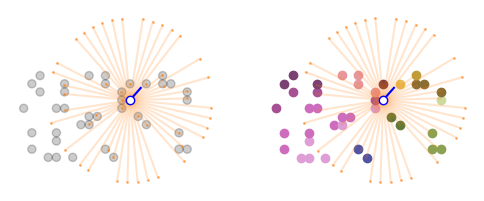

In [15]:
map_args    = (map_size=(21,11), res=1., pr=0.2)
sensor_args = (fov=180, n=50, max_val=10.)

M     = map_prior(map_args...)
pose  = pose_prior(M)
occ   = occupied(M)
sense, I = polar_lidar(occ, pose, sensor_args...)

#-----------------------
fig, axs = plt.subplots(1,2,figsize=(6,3), gridspec_kw=Dict("width_ratios" => [2,2]));
for ax in axs ax.axis("off"); ax.set_aspect(1); end;
draw_sense!(sense, pose; ax=axs[1])
draw_map_circles!(M; ax=axs[1])
draw_pose!(pose; ax=axs[1], c="b", l=2., zorder=2);

draw_pose!(pose; ax=axs[2], c="b", l=2., zorder=2);
draw_sense!(sense, pose; ax=axs[2])

cm = plt.cm.get_cmap("tab20b")
for (i,c) in enumerate(occ)
    axs[2].scatter(c.x..., c=[cm(I[i]/sensor_args.n)])
end

## Benchmark

In [16]:
map_args    = (map_size=(200,200), res=1., pr=0.2)
sensor_args = (fov=180, n=100, max_val=10.)

M     = map_prior(map_args...)
pose  = pose_prior(M)
occ   = occupied(M)
sense = polar_lidar(occ, pose, sensor_args...)

@benchmark polar_lidar(occ, pose, sensor_args...)

BenchmarkTools.Trial: 
  memory estimate:  2.05 MiB
  allocs estimate:  16866
  --------------
  minimum time:     2.327 ms (0.00% GC)
  median time:      2.831 ms (0.00% GC)
  mean time:        3.119 ms (7.53% GC)
  maximum time:     10.777 ms (64.40% GC)
  --------------
  samples:          1599
  evals/sample:     1

# Sensor model in Gen

In [17]:
sensor_mixture = HeterogeneousMixture([normal; uniform])


struct MultivariateSensor <: Gen.Distribution{Vector{Float64}} end
const mvsensor = MultivariateSensor()
function Gen.logpdf(::MultivariateSensor, z::AbstractArray{Float64,1}, 
                    mu::AbstractArray{Float64,1}, sig::Float64, max_val::Float64, w::Float64) 
    n = length(mu)
    f = map((i) -> Gen.logpdf(sensor_mixture, z[i], [1.0-w, w], mu[i], sig, 0.0, max_val), 1:n)
    f = sum(f)
    return f
end
function Gen.random(::MultivariateSensor, 
                    mu::AbstractArray{Float64,1}, sig::Float64, max_val::Float64, w::Float64)
    n = length(mu)
    z = [sensor_mixture([1.0-w, w], mu[i], sig, 0.0, max_val) for i=1:n]
    return z
end
(::MultivariateSensor)(mu::AbstractArray{Float64,1}, 
                       sig::Float64, 
                       max_val::Float64, 
                       w::Float64) = Gen.random(MultivariateSensor(), mu, sig, max_val, w)

Gen.has_output_grad(::MultivariateSensor) = false;
Gen.has_argument_grads(::MultivariateSensor) = (false,false,false,false);

In [18]:
"""
    Measurement(z, a) = sensor_model(M::Map, pose::Pose, fov, n, z_noise, max_val, drop_out)

Range sensor model for an occupancy map.

Choices:
```
    |
    +-- :z : Array{Float64, 1}
```
"""
@gen (static) function sensor_model(M::Map, pose::Pose, fov, n, max_val, noise, drop_out)
    
    (z0, a), ignore = polar_lidar(occupied(M), pose, fov, n, max_val)
    z  = @trace(mvsensor(z0, noise, max_val, drop_out), :z)
    
    return Measurement(z, a)
end;

Gen.load_generated_functions()

# Rem: Could add noise to the angles as well...
# ---

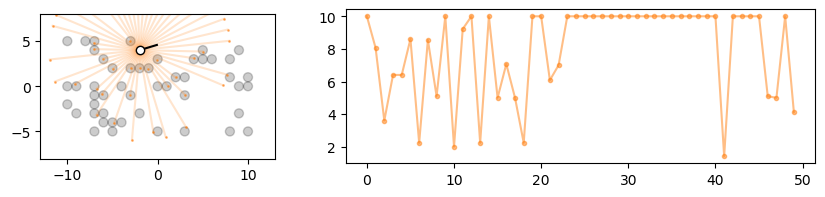

In [19]:
map_args    = (map_size=(21,11), res=1., pr=0.2)
sensor_args = (fov=180, n=50, max_val=10., noise=0.0, drop_out=0.0)

M    = map_prior(map_args...)
pose = pose_prior(M)


tr = simulate(sensor_model, (M, pose, sensor_args...))
sense = get_retval(tr)

#-----------------------
fig, axs = plt.subplots(1,2,figsize=(10,2), gridspec_kw=Dict("width_ratios" => [2,4]));
axs[1].set_xlim(bounds(M, 3)[1,:]...)
axs[1].set_ylim(bounds(M, 3)[2,:]...)
draw_sense!(sense, pose; ax=axs[1])
draw_map_circles!(M; ax=axs[1])
draw_pose!(pose; ax=axs[1], c="black", l=2., zorder=2);
axs[2].plot(sense.z, marker=".", c="C1", alpha=0.5)
# plt.savefig("png/sensor_and_occ.png")

## Benchmark

In [20]:
map_args    = (map_size=(200,200), res=1., pr=0.2)
sensor_args = (fov=180, n=100, max_val=10., noise=1.0, drop_out=0.0)

M    = map_prior(map_args...)
pose = pose_prior(M)

@benchmark simulate(sensor_model, (M, pose, sensor_args...))

BenchmarkTools.Trial: 
  memory estimate:  2.54 MiB
  allocs estimate:  22733
  --------------
  minimum time:     3.109 ms (0.00% GC)
  median time:      3.315 ms (0.00% GC)
  mean time:        3.665 ms (7.87% GC)
  maximum time:     10.011 ms (60.41% GC)
  --------------
  samples:          1362
  evals/sample:     1

# Inverse sensor model


- Ground truth sensor measurement; so we can test the inverse model

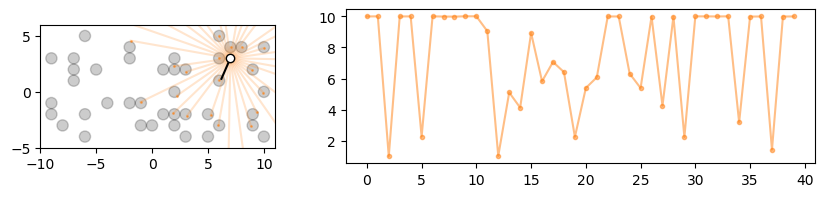

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdd92267c90>

In [21]:
map_args    = (map_size=(20,10), res=1., pr=0.2)
sensor_args = (fov=180, n=40, max_val=10., noise=0.01, drop_out=0.0)

m0    = map_prior(map_args...)
pose = pose_prior(m0)
sense = sensor_model(m0, pose, sensor_args...)

#-----------------------
fig, axs = plt.subplots(1,2,figsize=(10,2), gridspec_kw=Dict("width_ratios" => [2,4]));
axs[1].set_xlim(bounds(m0, 1)[1,:]...)
axs[1].set_ylim(bounds(m0, 1)[2,:]...)
draw_sense!(sense, pose; ax=axs[1])
draw_map_circles!(m0; ax=axs[1])
draw_pose!(pose; ax=axs[1], c="black", l=2., zorder=2);
axs[2].plot(sense.z, marker=".", c="C1", alpha=0.5)

In [22]:
"""
    inverse_polar_lidar!(M::Map, pose::Pose, sense::Measurement, free, prior, occ)

Based on the Bayesian map update from Table 9.1 in [Thrun et al., 2006].
"""
function inverse_polar_lidar!(M::Map, pose::Pose, sense::Measurement, z_eps, free, prior, occ)
    z,a = sense    

    for c in M.cells
        x = c.x - pose.x
        b = atan(x[2], x[1]) .- pose.hd
        k = argmin(s1_dist.(b, a))
        
        l = prior
        if norm(x) < z[k] - z_eps
            l = free
        elseif abs(norm(x) - z[k]) < z_eps
            l = occ
        end
        c.v = c.v + l - prior
    end 
end;

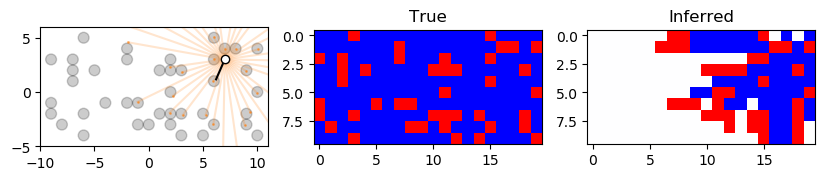

In [23]:
ell_map = Map(size(m0), m0.res, ell(0.5))

eps = M.res
inverse_polar_lidar!(ell_map, pose, sense, eps, ell(0.2), ell(0.5), ell(0.8))
im = expit(ell_map)

# --------------------
fig, axs = plt.subplots(1,3,figsize=(10,2), gridspec_kw=Dict("width_ratios" => [2,2,2]))
axs[1].set_xlim(bounds(m0, 1)[1,:]...)
axs[1].set_ylim(bounds(m0, 1)[2,:]...)
axs[2].set_title("True")
axs[3].set_title("Inferred")
draw_sense!(sense, pose; ax=axs[1])
draw_map_circles!(m0; ax=axs[1])
draw_pose!(pose; ax=axs[1], c="black", l=2., zorder=2);
draw_map_im!(val.(m0.cells), cmap="bwr", vmin=0, vmax=1, ax=axs[2])
draw_map_im!(im, cmap="bwr", vmin=0.2, vmax=0.8, ax=axs[3])
# plt.savefig("png/inverse_sensor.png")